# Coexisting processes (SIR + UAU) + multilayer (AUCS)

This experiment shows the difference between SIR and SIR + UAU

In [47]:
import network_diffusion as nd
import networkx as nx
import numpy as np
import pandas as pd

import functions
import models
from network_diffusion.models.utils.compartmental import CompartmentalGraph
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Toy example on one model

In [31]:
# define processes, allowed states and initial % of actors in that states
phenomena = {"contagion": [["S", "I", "R"], [90, 5, 5]], "awareness": [["U", "A"], [95, 5]]}

# wrap them into a compartments 
comp_g = CompartmentalGraph()
for phenomenon, [states, budget] in phenomena.items():
    comp_g.add(process_name=phenomenon, states=states)  # name of process
    comp_g.seeding_budget.update({phenomenon: budget})  # initial %s
comp_g.compile(background_weight=0)

# set up weights of transitions that are interesting for us
comp_g.set_transition_fast("contagion.S", "contagion.I", ("awareness.U", ), 0.2)
comp_g.set_transition_fast("contagion.S", "contagion.I", ("awareness.A", ), 0.05)
comp_g.set_transition_fast("contagion.I", "contagion.R", ("awareness.U", ), 0.3)
comp_g.set_transition_fast("contagion.I", "contagion.R", ("awareness.A", ), 0.6)
comp_g.set_transition_fast("awareness.U", "awareness.A", ("contagion.S", ), 0.05)
comp_g.set_transition_fast("awareness.U", "awareness.A", ("contagion.I", ), 0.8)
comp_g.set_transition_fast("awareness.U", "awareness.A", ("contagion.R", ), 1)

# create a DSAA model that implements propagation mechanism we are going to use
model = nd.models.DSAAModel(compartmental_graph=comp_g)
print(model)

DSAA Model
--------------------------------------------
compartmental model
--------------------------------------------
processes, their states and initial sizes:
	'contagion': [S:90%, I:5%, R:5%]
	'awareness': [U:95%, A:5%]
--------------------------------------------
process 'contagion' transitions with nonzero weight:
	from S to I with probability 0.2 and constrains ['awareness.U']
	from I to R with probability 0.3 and constrains ['awareness.U']
	from S to I with probability 0.05 and constrains ['awareness.A']
	from I to R with probability 0.6 and constrains ['awareness.A']
--------------------------------------------
process 'awareness' transitions with nonzero weight:
	from U to A with probability 0.05 and constrains ['contagion.S']
	from U to A with probability 0.8 and constrains ['contagion.I']
	from U to A with probability 1 and constrains ['contagion.R']
seed selection method
--------------------------------------------
	nodewise random choice



In [30]:
net = nd.MultilayerNetwork.from_nx_layer(
    network_layer=nx.erdos_renyi_graph(n=100, p=0.2), layer_names=phenomena.keys()
)
print(net)

network parameters
--------------------------------------------
general parameters:
	number of layers: 2
	number of actors: 1000

layer 'contagion' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 1000
	number of edges - 99446
	average degree - 198.892
	clustering coefficient - 0.1989

layer 'awareness' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 1000
	number of edges - 99446
	average degree - 198.892
	clustering coefficient - 0.1989


In [32]:
all_logs = []
for i in tqdm(range(30)):
    experiment = nd.Simulator(model, net.copy())
    run_logs = experiment.perform_propagation(n_epochs=10, patience=None)
    all_logs.append(run_logs._global_stats_converted)

100%|██████████| 30/30 [02:24<00:00,  4.81s/it]


In [33]:
mean_contagion = functions.get_mean_log([log["contagion"] for log in all_logs])
mean_awareness = functions.get_mean_log([log["awareness"] for log in all_logs])

In [34]:
mean_core = pd.DataFrame([mean_contagion["I"], mean_awareness["A"]]).T

<Axes: >

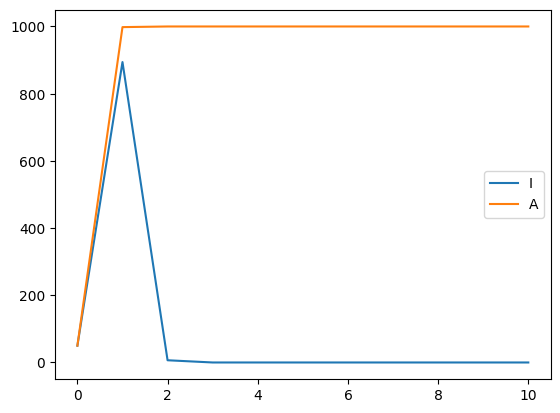

In [35]:
import matplotlib.pyplot as plt

mean_core.plot()

### Real experiments

In [78]:
N_EPOCHS = 50
N_REPETITIONS = 30
PATIENCE = None
LAMBDAS = [0, 0.5, 1, 1.5, 2]

In [79]:
net = nd.MultilayerNetwork.from_nx_layer(
    network_layer=nx.erdos_renyi_graph(n=100, p=0.2), layer_names=phenomena.keys()
)
print(net)

network parameters
--------------------------------------------
general parameters:
	number of layers: 2
	number of actors: 100

layer 'contagion' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 100
	number of edges - 973
	average degree - 19.46
	clustering coefficient - 0.2007

layer 'awareness' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 100
	number of edges - 973
	average degree - 19.46
	clustering coefficient - 0.2007


In [80]:
results = {}

for l in LAMBDAS:
    print(f"Model with lambda: {l}")
    model = models.get_flu_model(l=l)

    all_logs = []
    for i in tqdm(range(N_REPETITIONS)):
        experiment = nd.Simulator(model, net.copy())
        run_logs = experiment.perform_propagation(n_epochs=N_EPOCHS, patience=PATIENCE)
        all_logs.append(run_logs._global_stats_converted)

    mean_contagion = functions.get_mean_log([log["contagion"] for log in all_logs])
    mean_awareness = functions.get_mean_log([log["awareness"] for log in all_logs])
    mean_core = pd.DataFrame([mean_contagion["I"], mean_awareness["A"]]).T

    results[l] = mean_core

Model with lambda: 0


100%|██████████| 30/30 [00:03<00:00,  8.37it/s]


Model with lambda: 0.5


100%|██████████| 30/30 [00:03<00:00,  8.79it/s]


Model with lambda: 1


100%|██████████| 30/30 [00:03<00:00,  8.97it/s]


Model with lambda: 1.5


100%|██████████| 30/30 [00:03<00:00,  9.03it/s]


Model with lambda: 2


100%|██████████| 30/30 [00:03<00:00,  9.06it/s]


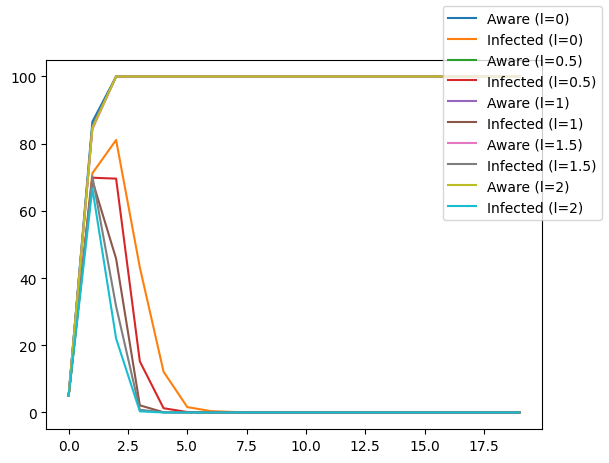

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=1)
for l, result in results.items():
    _a = result["A"].to_numpy()[:20]
    ax.plot(np.arange(0, len(_a)), _a, label=f"Aware (l={l})")

    _i = result["I"].to_numpy()[:20]
    ax.plot(np.arange(0, len(_i)), _i, label=f"Infected (l={l})")

fig.legend()